In [1]:
import pymysql
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy import stats
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.optimize import minimize
import pickle
from scipy.stats import pearsonr

In [2]:
def calculate_speedup_ratio_amdahl(workload, processors, bottlenecks, task):
    if processors == 1:
        return 0

    p = 0.5
    s = np.minimum(processors, bottlenecks) / np.minimum(processors-1, bottlenecks)
    speedup = 1 / ((1-p) + (p/s))
        
    return np.log(1/(speedup * workload))

# Classic social loafing models

def linear_socialloafing(p):
    return p

def nonlinear_socialloafing(p):
    return np.log(p)

# Norm-based models

def group_size_model(group_size):
    return (group_size-1) / (group_size)

# Workload models

def simplewkld_model(w):
    return 1 / w

def wkldeffort_model(w):
    a = -0.1
    b = 0.8
    c = 2
    
    return a * w**2 + b * w + c

def getspeedups(workloads, processors, task, bottleneck, model):
    speedups = {key: [] for key in workloads}
    for p in processors:
        for i in workloads:
            if model == "amdahl":
                speedup = calculate_speedup_ratio_amdahl(i, p, bottleneck, task)
            elif model == "groupsize":
                speedup = group_size_model(p)
            elif model == "workload":
                speedup = simplewkld_model(i)
            elif model == "workload_effort":
                speedup = wkldeffort_model(i)
            elif model == "sl_linear":
                speedup = linear_socialloafing(i, p, task)
            elif model == "sl_nonlinear":
                speedup = nonlinear_socialloafing(i, p, task)
            elif model == "norms":
                speedup = 1/p
            speedups[i].append(speedup)
    return speedups

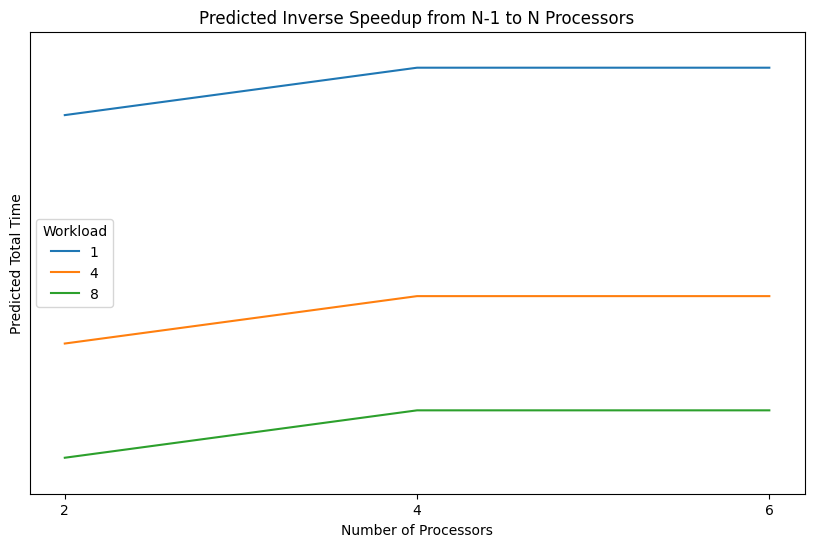

In [3]:
processors = [2,4,6]
workloads = [1,4,8]

dishes_speedups = getspeedups(workloads, processors, "dishes", 2, "amdahl")
carrot_speedups = getspeedups(workloads, processors, "carrots", 2, "amdahl")

plt.figure(figsize=(10, 6))
for workload in dishes_speedups.keys():
    avg_speedups = np.asarray([sum(x) for x in zip(carrot_speedups[workload], dishes_speedups[workload])]) / 2
    plt.plot(processors, avg_speedups, label=f"{workload}", linestyle='-')

plt.xlabel("Number of Processors")
plt.ylabel("Predicted Total Time")
plt.title("Predicted Inverse Speedup from N-1 to N Processors")
plt.legend(title='Workload')
plt.xticks([2.0, 4.0, 6.0])
ymin, ymax = plt.ylim()
plt.ylim(ymin-0.1, ymax+0.1)
plt.yticks([])
plt.show()

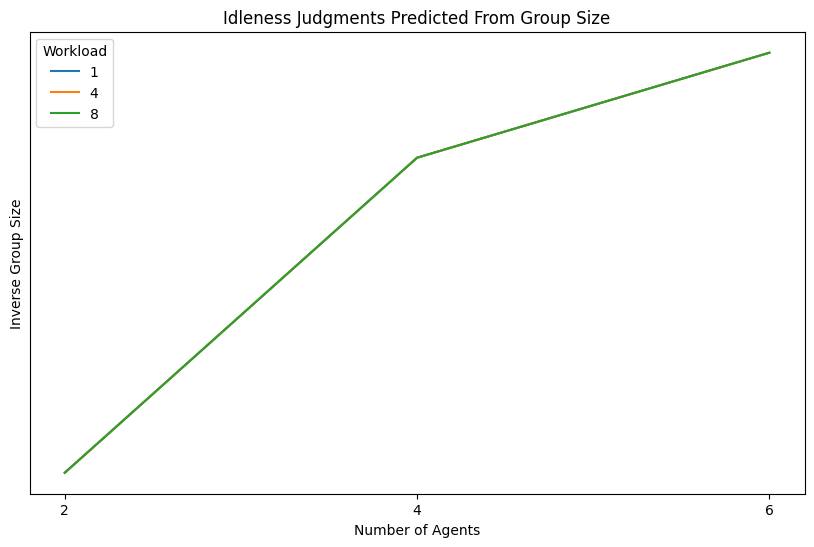

In [4]:
dishes_speedups = getspeedups(workloads, processors, "dishes", 2, "groupsize")
carrot_speedups = getspeedups(workloads, processors, "carrots", 2, "groupsize")

plt.figure(figsize=(10, 6))
for workload in dishes_speedups.keys():
    avg_speedups = np.asarray([sum(x) for x in zip(dishes_speedups[workload], dishes_speedups[workload])]) / 2
    plt.plot(processors, avg_speedups, label=f"{workload}", linestyle='-')

plt.xlabel("Number of Agents")
plt.ylabel("Inverse Group Size")
plt.title("Idleness Judgments Predicted From Group Size")
plt.legend(title='Workload')
plt.xticks([2.0, 4.0, 6.0])
plt.yticks([])
plt.show()

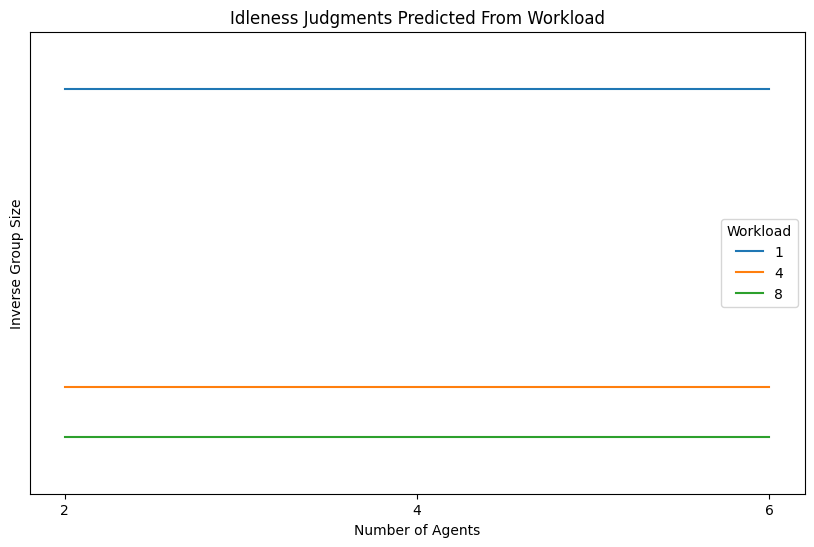

In [5]:
dishes_speedups = getspeedups(workloads, processors, "dishes", 2, "workload")
carrot_speedups = getspeedups(workloads, processors, "carrots", 2, "workload")

plt.figure(figsize=(10, 6))
for workload in dishes_speedups.keys():
    avg_speedups = np.asarray([sum(x) for x in zip(dishes_speedups[workload], dishes_speedups[workload])]) / 2
    plt.plot(processors, avg_speedups, label=f"{workload}", linestyle='-')

plt.xlabel("Number of Agents")
plt.ylabel("Inverse Group Size")
plt.title("Idleness Judgments Predicted From Workload")
plt.legend(title='Workload')
plt.xticks([2.0, 4.0, 6.0])
ymin, ymax = plt.ylim()
plt.ylim(ymin-0.1, ymax+0.1)
plt.yticks([])
plt.show()

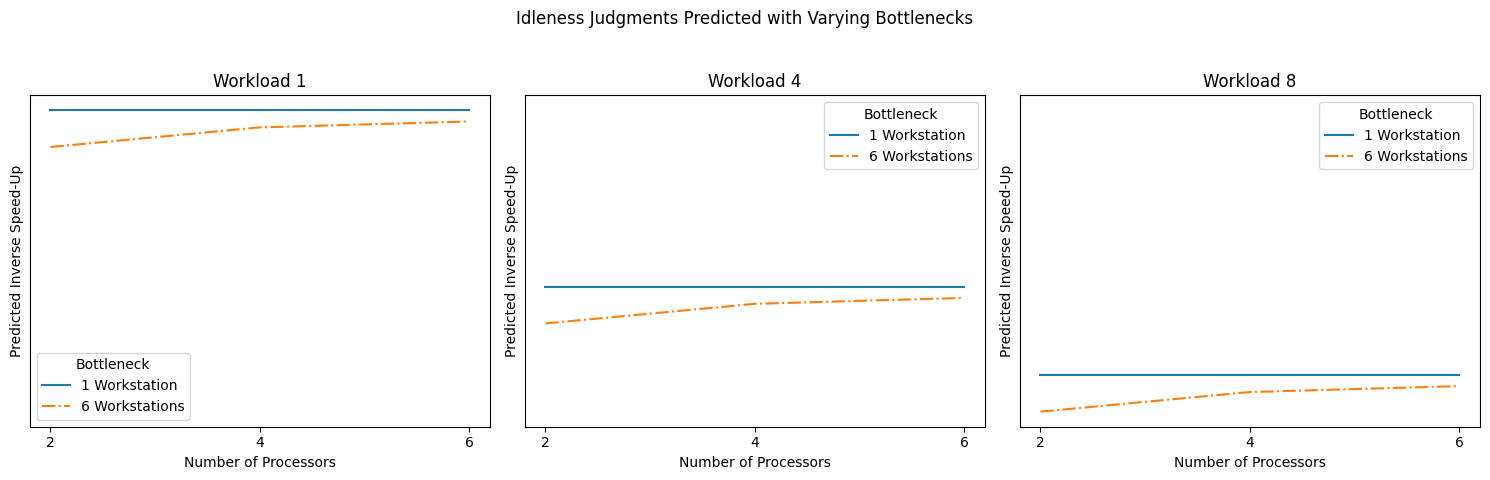

In [6]:
processors = [2,4,6]

dishes_speedups_b1 = getspeedups(workloads, processors, "dishes", 1, "amdahl")
dishes_speedups_b6 = getspeedups(workloads, processors, "dishes", 6, "amdahl")

carrot_speedups_b1 = getspeedups(workloads, processors, "carrots", 1, "amdahl")
carrot_speedups_b6 = getspeedups(workloads, processors, "carrots", 6, "amdahl")

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for workload, ax in zip(workloads, axs.flatten()):
    avg_speedups_b1 = np.asarray([sum(x) for x in zip(dishes_speedups_b1[workload], carrot_speedups_b1[workload])]) / 2
    avg_speedups_b6 = np.asarray([sum(x) for x in zip(dishes_speedups_b6[workload], carrot_speedups_b6[workload])]) / 2

    ax.plot(processors, avg_speedups_b1, label=f"1 Workstation", linestyle='-')
    ax.plot(processors, avg_speedups_b6, label=f"6 Workstations", linestyle='-.')

    ax.set_xlabel("Number of Processors")
    ax.set_ylabel("Predicted Inverse Speed-Up")
    ax.set_title(f"Workload {workload}")
    ax.legend(title='Bottleneck')
    ax.set_xticks([2.0, 4.0, 6.0])
    ax.set_yticks([])

plt.suptitle("Idleness Judgments Predicted with Varying Bottlenecks")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

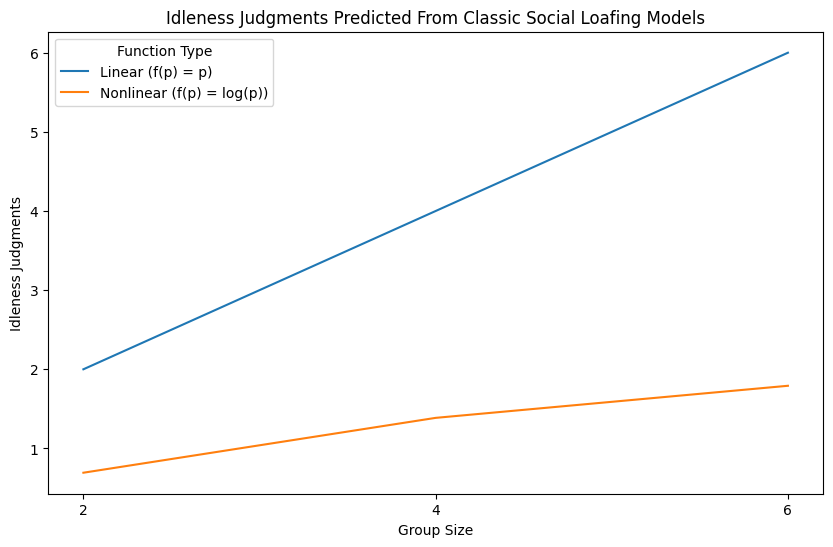

In [7]:
group_sizes = np.array([2, 4, 6])
alpha = 1.0

y_linear = alpha * linear_socialloafing(group_sizes)
y_nonlinear = alpha * nonlinear_socialloafing(group_sizes)

# Plotting
plt.figure(figsize=(10, 6))

# Linear function plot
plt.plot(group_sizes, y_linear, label="Linear (f(p) = p)", linestyle='-')

# Nonlinear function plot
plt.plot(group_sizes, y_nonlinear, label="Nonlinear (f(p) = log(p))", linestyle='-')

# Labels and title
plt.xlabel("Group Size")
plt.ylabel("Idleness Judgments")
plt.title("Idleness Judgments Predicted From Classic Social Loafing Models")
plt.legend(title='Function Type')
plt.xticks(group_sizes)
plt.grid(False)

# Show plot
plt.show()